# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

# Problem statement and Approach

In scope of this program and with the data presented, we will looking at the association of promotion types, customer demographics and transaction records. The maingoals are:

**1. Which promotion would return the best outcome?**

The "best" outcome measured by the reach to audience and amount spending on each promotion. This is comprarison of one promotion versus the other over the sampling of customers (all customers/users in dataset)

**2. Which group of customer would enjoy the promotion or which promotion is prefer?**

This measured by comparative data from other group similar to a the same promotion. This is subset data, in which one group of users are compared to other or the rest of users to a certain promotion or offer

**3. Could we recommend a user a certain promotion, knowing that there is similarity of this user vs. other similar users in the dataset?**

Essentially, for \#3 we can build a recommendation system having following concepts:
- if user is in the data base, we can check the performance on received offers vs. the most similar n users. We then recommend the ranked offer that the group with n users responded in the dataset. The performance could be measured by completion records or actually dollars purchased
- if we don't have anything information of the user, we could send the most successful promotion on the step 1, measured by completion response or by dollars purchased.

# Data Exploration

In [1]:
import warnings
warnings.filterwarnings('ignore') # make the output cleaner

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 13
plt.rcParams['font.sans-serif'] = 'Open Sans'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#4c4c4c'
plt.rcParams['axes.labelcolor']= '#4c4c4c'
plt.rcParams['xtick.color'] = '#4c4c4c'
plt.rcParams['ytick.color'] = '#4c4c4c'

In [3]:
import pandas as pd
import numpy as np
import math
import json

In [4]:
# one analysis could ran for 20 minutes, the LOAD_JSON option here let us load file from a json file
# else the actually iteration will take place
LOAD_JSON = True

## Portfolio

In [5]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


three types of promotion:

- **BOGO (Buy One Get One free)**: customer received this offer, customer can get two similar drinks and pay for one, essentially 50% except customer now have two drinks, works better for customer who has a friend or a colleague to join that drink
- **Discount**: after certain dollars purchased for example \\$10, then a reward of \\$5 is added to buyers' Starbucks account
- **Informational**: a notice or email informing a new product, or a new type of service. Customer is considered under *influence* during valid period if customer **viewed** the offer

There are four types of BOGO, four types of discounts, and two types of informational included in this campaign. We will comback with this **portfolio** data after seeing more date in **transcript**

## Profile

In [6]:
# load data in show first 5 lines
profile = pd.read_json('data/profile.json', orient='records', lines=True)
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
# shape: rows by columns
profile.shape

(17000, 5)

In [8]:
profile.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [9]:
# genders
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

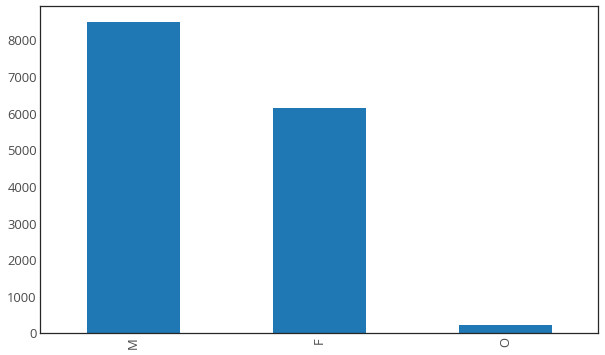

In [10]:
profile.gender.value_counts().plot(kind='bar');

In [11]:
# age distribution, we saw some discrepancy with 118 (years old)
profile.age.value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [12]:
# abnormal with 118 value, setting by NaN
profile.loc[profile['age']==118, 'age'] = np.NaN

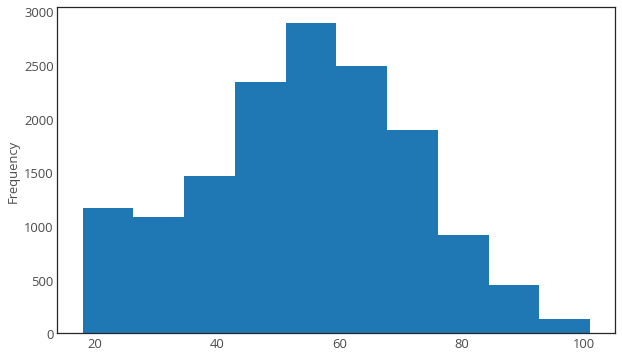

In [13]:
# all genders
profile.age.plot.hist();

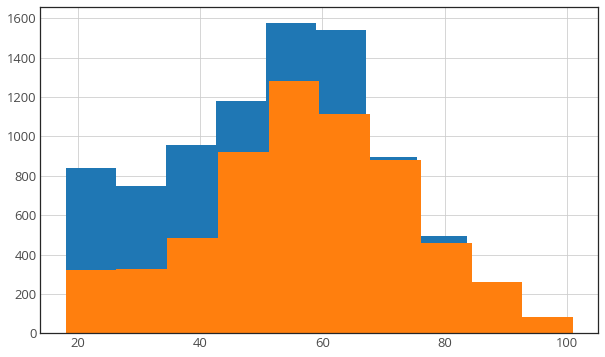

In [14]:
# distribution of age by gender
profile.query('gender=="M"')['age'].hist()
profile.query('gender=="F"')['age'].hist();

- clear more young male members than female members in the dataset. It makes sense since Starbuck sells coffee as the main drink, 

In [15]:
# let group genders and age 
gender = profile.groupby(['age', 'gender']).count()['id'].unstack()
gender

gender,F,M,O
age,,,
18.0,14.0,56.0,NaN
19.0,31.0,104.0,NaN
20.0,35.0,96.0,4.0
21.0,41.0,96.0,3.0
22.0,46.0,84.0,1.0
...,...,...,...
97.0,6.0,7.0,NaN
98.0,2.0,3.0,NaN
99.0,4.0,1.0,NaN


In [16]:
gender['M/F'] = gender['M']/gender['F']

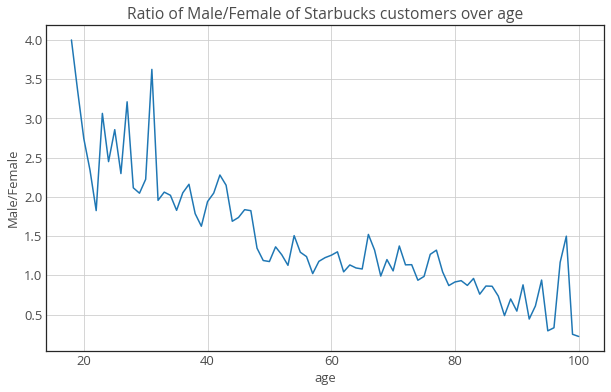

In [17]:
plt.title('Ratio of Male/Female of Starbucks customers over age')
plt.ylabel('Male/Female')
plt.xlabel('age')
plt.grid()
plt.plot(gender.index, gender['M/F']);

- more male customers under 40, and female customers are increased propotionally with age
- over 80 years old, more female than male using Starbucks products (or as Starbucks customer)

In [18]:
# explore member join 
profile['became_member_on'] = pd.to_datetime(profile.became_member_on, format='%Y%m%d')

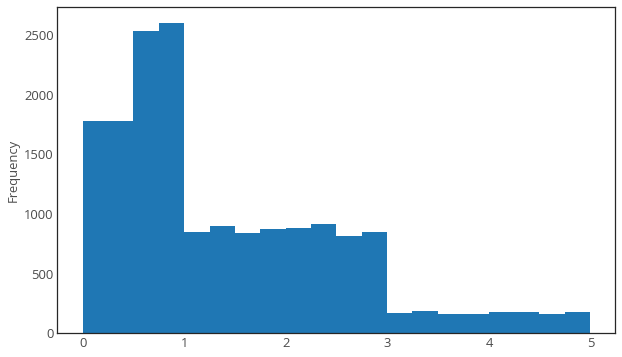

In [19]:
latest_ts = profile.became_member_on.max()
profile.became_member_on.apply(lambda x: (latest_ts - x).total_seconds()/
                               (3600*24*365)).plot(kind='hist', bins=20);

In [20]:
profile['membership_age'] = profile.became_member_on.apply(lambda x: int((latest_ts - x).total_seconds()/
                               (3600*24*365)))

In [21]:
# portion with nans in incomes
profile.income.isna().sum()/profile.shape[0]

0.12794117647058822

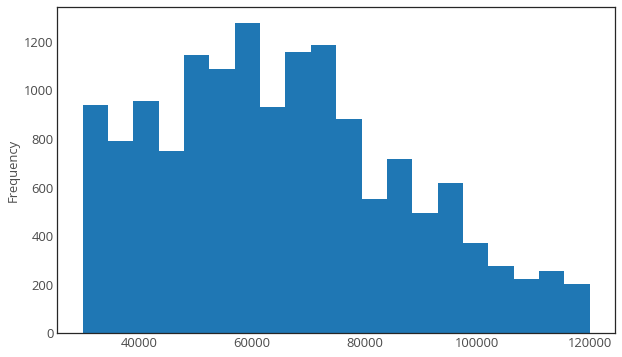

In [22]:
profile.income.plot(kind='hist', bins=20);

In [23]:
profile.head()

,gender,age,id,became_member_on,income,membership_age
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,1
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0


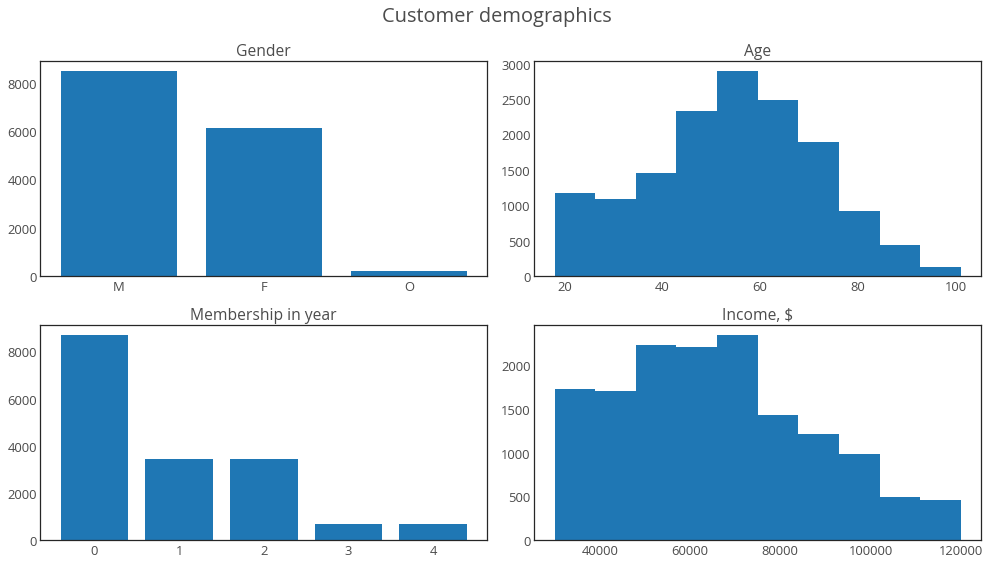

In [24]:
# make a combined graph
fig, axs = plt.subplots(2,2, figsize=(14,8))
fig.suptitle('Customer demographics', fontsize=20)
df_ = profile.gender.value_counts()
axs[0,0].set_title('Gender')
axs[0,0].bar(x = df_.index, height=df_.values)
axs[0,1].set_title('Age')
axs[0,1].hist(profile.age)
axs[1,1].set_title('Income, $')
axs[1,1].hist(profile.income)
df_ = profile.membership_age.value_counts()
axs[1,0].set_title('Membership in year')
axs[1,0].bar(x=df_.index, height=df_.values)
fig.tight_layout()
fig.savefig('img/profile.png', optimize=True, dpi=200);

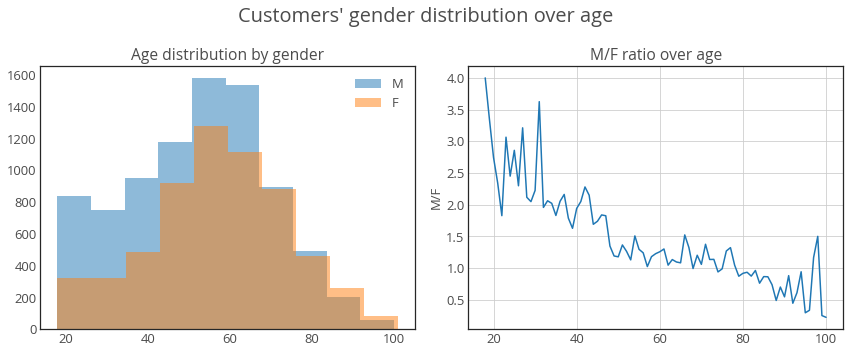

In [25]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Customers\' gender distribution over age', fontsize=20)
m = profile.query('gender=="M"')['age']
fm = profile.query('gender=="F"')['age']

axs[0,].set_title('Age distribution by gender')
axs[0,].hist(m.values, alpha=0.5, label='M')
axs[0,].hist(fm.values, alpha=0.5, label='F')
axs[0].legend()

axs[1,].set_title('M/F ratio over age')
axs[1,].set_ylabel('M/F')
axs[1,].plot(gender.index, gender['M/F']);
axs[1,].grid()
# fig.legend()
fig.tight_layout()
fig.savefig('img/age_dist.png', optimize=True, dpi=200);

### encoded profile

In [26]:
# for columns with a few categorical values, we can get encode them direcly such as gender, became_member_on
# other need to be cut into a larger bin and then encoded by pd.get_dummies
# will we find a similar customer based on characteristics from profile
profile.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income', 'membership_age'], dtype='object')

In [27]:
# membership age
profile['membership_age'] = profile.became_member_on.apply(lambda x: int((latest_ts - x).total_seconds()/
                               (3600*24*365)))
df_m_age = pd.get_dummies(profile.membership_age, prefix="m_age", dummy_na=True)

In [28]:
# genders
df_gender = pd.get_dummies(profile.gender, prefix="gender", dummy_na=True)

In [29]:
# for age columns, we have 84 members, which is is too large to encoded for each year
profile.age.value_counts()

58.0     408
53.0     372
51.0     363
54.0     359
59.0     359
        ... 
100.0     12
96.0       8
101.0      5
99.0       5
98.0       5
Name: age, Length: 84, dtype: int64

In [30]:
# instead we gather in to a bin of 10 years
min_, max_ = profile.age.describe().loc['min'], profile.age.describe().loc['max']
min_, max_

(18.0, 101.0)

In [31]:
age_bins = np.arange(min_, max_+1, 10)
age_labels = [int((age_bins[i]+age_bins[i+1])/2) for i in range(0, len(age_bins)-1)]
age_labels # average values

[23, 33, 43, 53, 63, 73, 83, 93]

In [32]:
df_age = pd.get_dummies(pd.cut(profile.age, bins=age_bins, 
                      labels = age_labels), prefix="age", dummy_na=True)

In [33]:
# and finally income
profile.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [34]:
# similar to age, we bins income to smaller groups
min_, max_ = profile.income.describe().loc['min'], profile.income.describe().loc['max']
income_bins = np.arange(min_, max_+1, 10_000)
income_labels = [int((income_bins[i]+income_bins[i+1])/2) for i in range(0, len(income_bins)-1) ]
income_labels # average values

[35000, 45000, 55000, 65000, 75000, 85000, 95000, 105000, 115000]

In [35]:
df_income = pd.get_dummies(pd.cut(profile.income, bins=income_bins, 
                      labels = income_labels), prefix="income", dummy_na=True)

In [36]:
# then we concat all users with encoded columns
profile_encoded = pd.concat([profile.id, df_gender, df_age, df_income, df_m_age], axis=1)
profile_encoded.set_index('id', inplace=True)
profile_encoded.shape

(17000, 29)

In [37]:
# see what np.dot production looks like
np.dot(profile_encoded.iloc[1], profile_encoded.iloc[1])

4

In [38]:
def encoding_profile(df=None):
    '''encode values of columns in user profile.
    
    INPUT: user profile dataframe
    
    OUTPUT: a dataframe with value encoded
    '''
    
    # membership age
    df['membership_age'] = df.became_member_on.apply(
        lambda x: int((latest_ts - x).total_seconds()/(3600*24*365)))
    df_m_age = pd.get_dummies(df.membership_age, prefix="m_age", dummy_na=True)
    
    # gender
    df_gender = pd.get_dummies(df.gender, prefix="gender", dummy_na=True)
    min_, max_ = df.age.describe().loc['min'], df.age.describe().loc['max']
    
    # user age
    age_bins = np.arange(min_, max_+1, 10)
    age_labels = [int((age_bins[i]+age_bins[i+1])/2) for i in range(0, len(age_bins)-1)]
    df_age = pd.get_dummies(pd.cut(df.age, bins=age_bins, 
                      labels = age_labels), prefix="age", dummy_na=True)
    
    # user income
    min_, max_ = df.income.describe().loc['min'], df.income.describe().loc['max']
    income_bins = np.arange(min_, max_+1, 10_000)
    income_labels = [int((income_bins[i]+income_bins[i+1])/2) for i in range(0, len(income_bins)-1)]
    df_income = pd.get_dummies(pd.cut(df.income, bins=income_bins, 
                      labels = income_labels), prefix="income", dummy_na=True)
    # concatinate
    profile_encoded = pd.concat([df.id, df_gender, df_age, df_income, df_m_age], axis=1)
    profile_encoded.set_index('id', inplace=True)
    return profile_encoded

In [39]:
def find_similar_users(user_id, df=None, n_top=100):
    '''find n_top similars to user_id based np.dot product
    
    INPUT:
        user_id: a select user id 
        df: a dataframe contains encoded columns characterize each user
        n_top: number of top users would be return
    
    OUTPUT:
        a dictionary contain a list of user_id and similar score    
    '''
    # select all users except the user_id
    users = df.index.drop(user_id)
    
    # find similarity  
    scores = [{'user': user, 'score':np.dot(df.loc[user_id], 
                                            df.loc[user])} for user in users]
    # sort from top score
    scores = sorted(scores, key=lambda k: k['score'], reverse=True)
    return scores[:n_top]

In [40]:
# select a user based on index
user_id = profile_encoded.index[100]
user_id

'13bda8fbd70a4814b956df1d55320398'

In [41]:
profile_encoded = encoding_profile(df=profile)

In [42]:
profile_encoded.head()

,gender_F,gender_M,gender_O,gender_nan,age_23.0,age_33.0,age_43.0,age_53.0,age_63.0,age_73.0,...,income_95000.0,income_105000.0,income_115000.0,income_nan,m_age_0.0,m_age_1.0,m_age_2.0,m_age_3.0,m_age_4.0,m_age_nan
id,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
0610b486422d4921ae7d2bf64640c50b,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
38fe809add3b4fcf9315a9694bb96ff5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
78afa995795e4d85b5d9ceeca43f5fef,1,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
a03223e636434f42ac4c3df47e8bac43,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [43]:
find_similar_users(user_id, df=profile_encoded)

[{'user': 'cbebad9819494b479dbf0c1207b4c0c5', 'score': 4},
 {'user': '807199e7716f4d78974416f917582b78', 'score': 4},
 {'user': 'de4cc19481914b79b9bfbec4185de8c7', 'score': 4},
 {'user': '79526521cf4e4f45ad218c7ce25409f3', 'score': 4},
 {'user': '9a486e1f8a8941db9af401ad52af2ac9', 'score': 4},
 {'user': 'f8f12b89a9e740d881f21dbe62c05c22', 'score': 4},
 {'user': '8140d90b53c54b0687ddd58ee64bd9d6', 'score': 4},
 {'user': 'd8caa73d26d34770847f584020421eba', 'score': 4},
 {'user': '433615d15b654fc99fefa9cd1d0b1a48', 'score': 4},
 {'user': 'ae446077b3294f60bd40a5757d537744', 'score': 4},
 {'user': '930c6cd15edb4620ad557fe5e7bfeaac', 'score': 4},
 {'user': '664cdcbcc8b442078bcedac94dc227bb', 'score': 4},
 {'user': '894d620373384c5f8c25e28d15de7959', 'score': 4},
 {'user': '11fe137500b44584b5216902c274f0cb', 'score': 4},
 {'user': '924dd5009ef945d6816d0577cdcc0cd5', 'score': 4},
 {'user': 'b694ab6e982a4734be5bb6e0e7ec6e25', 'score': 4},
 {'user': 'c9efe52c3dd44130a07481a0f6274e10', 'score': 4

## Transcript

In [44]:
# transaction record
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [45]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [46]:
# long table
transcript.shape

(306534, 4)

In [47]:
# average traffic per user
transcript.shape[0]/transcript.person.nunique()

18.031411764705883

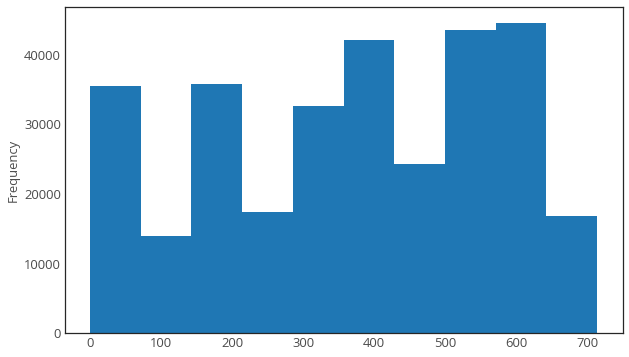

In [48]:
# transaction by timestamp  (hours)
transcript.time.plot(kind='hist');

In [49]:
# transaction categories
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

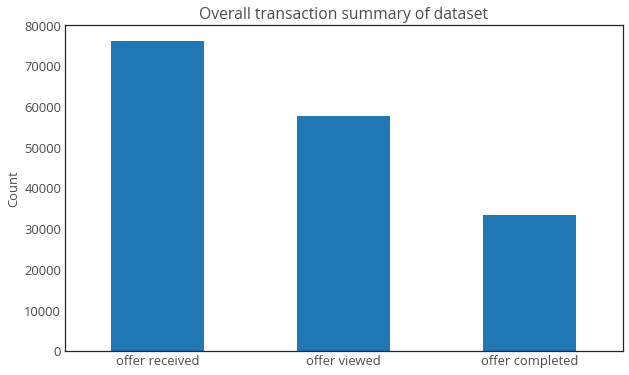

In [50]:
transcript.event.value_counts().iloc[1:].plot(kind='bar')
plt.xticks(rotation=0);
plt.ylabel('Count')
plt.title('Overall transaction summary of dataset');


- over the all transaction, about 44% promotion received gets completed
- 75% of promotions received gets viewed
- 58% of promotions viewed gets completed
- two informational promotions don't have "completed" record

### user-offer-matrix

In [51]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [52]:
# get content of value columns, unpack
transcript['amount'] = transcript['value'].apply(lambda x: list(x.values())[0] 
                                                 if 'amount' in list(x.keys())[0] else np.NaN)
transcript['offer'] = transcript['value'].apply(lambda x: list(x.values())[0] 
                                                if 'offer' in list(x.keys())[0] else np.NaN)

In [53]:
transcript.drop(columns='value', inplace=True)
transcript.shape

(306534, 5)

In [54]:
# let see total purchase in $M
transcript.amount.sum()/1_000_000

1.7754519700000004

In [55]:
# on average, customer make a $12.77, and 50% customers make $8.9 or more
transcript.amount.describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

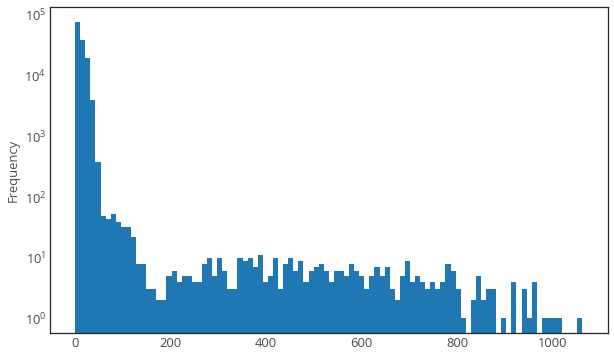

In [56]:
transcript.amount.plot(kind='hist', bins=100, logy=True);

In [57]:
# let see who make a $100 or more
transcript[transcript.amount > 100]

,person,event,time,amount,offer
15540,f367a50b86d049799bbb0eb645ee834c,transaction,0,195.24,NaN
18053,8a776d222f174aa089866b2725721eec,transaction,6,448.97,NaN
18417,6b247ba48509456eb57b24f878f313ea,transaction,12,219.02,NaN
18800,04f1f44632cd409cace939fa62b5fc7a,transaction,12,628.41,NaN
19097,a12fba072dae4e3aae2e1b4b92b92aa1,transaction,12,871.51,NaN
...,...,...,...,...,...
304828,10cbaa18d359457d899edf285d85a9b4,transaction,708,120.29,NaN
305143,76018bc0dfd64ccc8f2e7959bf627ba7,transaction,708,290.93,NaN
305567,a0f4c1aafeda4398a7afe66c37caf416,transaction,714,685.07,NaN
305925,692e3eaba5854ad5bbdd51d241647830,transaction,714,405.04,NaN


In [58]:
# look like we have some office parties, let see if we can filter out transaction outside 1.5IRQ
irq = transcript.amount.describe().loc['75%'] - transcript.amount.describe().loc['25%']
irq

15.29

In [59]:
upper_limit = transcript.amount.describe().loc['75%'] + 1.5*irq
upper_limit

41.004999999999995

In [60]:
transcript.shape

(306534, 5)

In [61]:
# seem we are losing more than 50% of transaction if we filter out
# we will proceed WITHOUT filter out,
transcript[transcript.amount < upper_limit].shape

(137717, 5)

In [62]:
# moving on to unique users
transcript.person.nunique()

17000

In [63]:
# first let tackle the promo with BOGO or discount
discount_bogo_ids = portfolio[portfolio['offer_type'] != 'informational'].id.values
discount_bogo_ids

array(['ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'fafdcd668e3743c1bb461111dcafc2a4',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5'], dtype=object)

In [64]:
# informational offer id
info_ids = portfolio[portfolio['offer_type'] == 'informational'].id.values
info_ids

array(['3f207df678b143eea3cee63160fa8bed',
       '5a8bc65990b245e5a138643cd4eb9837'], dtype=object)

- We need to rate how a promotion is sucess or not, for discout or BOGO, a **success case** this should be: 

    `offer received >> offer viewed >> offer completed`
- A **failed** promotion is:

    `offer received >> no view on offer >> offer completed`
basically, an offer made, customer did not know about an offer but still purchase goods to the minimum amount required by an offer. From pretext of the problem, it is not desirable since the marketing campaign had no influence on customer's purchase

- Another failed case: 

    `offer received >> offer viewed >> offer not completed` before time expired
- and another case: 

    `offer received >> no view on offer >> offer not completed` before time expired

the last one represents a case that is more complicated. We do not know offer not completed because they are not aware of a promotion or the promotion is not appeal enough to get it completed.

Let tackle problem by trying a simpler approach: rating a success/fail offer by looking in `viewed, completed` records. This approach is only applicable for 8 discounts or BOGO promotions. For informational ones, we could simplify by looking only to `viewed` records

## Simple rating based on records  of viewed, completed

In [65]:
def rate_offer_discount_bogo(offer_id, df=None):
    '''
    rate a offer based on average number of viewed to number of completed 
    and total offer received.
    
    score = number of completed / number of received (promotion)
    For example: 
    - if a customer received two offers, viewed two and completed two, the score is 1
    - if a customer received two, one viewed, completed 2, score is 2/2 = 1
    - if a customer received two, one viewed, completed 0, score is 0/2 = 0
    
    INPUT:
    offer_id: id of offer of discount or BOGO
    df: dataframe with promoting events (filter out transacion)
    
    OUTPUT: a dataframe with index as the users received the offer and the column name as the offer id
    '''
    
    df_group = df.query(f'offer==@offer_id').groupby(
        ['person', 'event']).count()['time'].unstack(fill_value=0)
    df_group = df_group.apply(lambda row: 
                              row['offer completed']/row['offer received']
                              if row['offer received']>0 else np.NaN, axis=1)
    return df_group.rename(offer_id).to_frame()

In [66]:
# for informational events, it is harder to evaluate influence of seeing the offer and the follow up transaction
# for a simple case, I will rate them based on viewed/received ratio
def rate_offer_info(offer_id, df=None):
    '''rate informational offer based number of viewed and received.
    rate = number of viewed/ number of received
    
    For example:
    - if all offers were viewed, the rate = 1
    - if none of offers were viewed, teh rate = 0
    
    INPUT: offer_id -  id for the offer
    OUTPUT: a dataframe with promoting events (filter out transacion)
    '''
    
    df_group = df.query('offer==@offer_id').groupby(
        ['person', 'event']).count()['time'].unstack(fill_value=0)
    df_group = df_group.apply(lambda row: row['offer viewed'] /row['offer received']
                         if row['offer received']>0 else np.NaN, axis=1)
    return df_group.rename(offer_id).to_frame()

In [67]:
dfs = list()
for offer_id in discount_bogo_ids:
    dft = rate_offer_discount_bogo(offer_id, df=transcript)
    dfs.append(dft)
# append to a list of dataframe on the previous step
for offer_id in info_ids:
    dft = rate_offer_info(offer_id, df=transcript)
    dfs.append(dft)

In [68]:
for df in dfs:
#     print(df.info())
    print(df.shape)

(6374, 1)
(6330, 1)
(6355, 1)
(6374, 1)
(6325, 1)
(6332, 1)
(6262, 1)
(6285, 1)
(6331, 1)
(6320, 1)


In [69]:
# check set of users received all offers
common_users = set(dfs[0].index)
for df in dfs[1:]:
    users = df.index
    common_users = common_users.intersection(users)
    print(len(common_users))
# none of user received all offers 

2118
604
127
36
4
0
0
0
0


In [70]:
# pd.concat is easier for applying, but only along columns or a along the rows which is less flexible
df = dfs[0]
for df_ in dfs[1:]:
    df = df.merge(df_, on='person', how='outer')
    print(df.shape)

(10586, 2)
(13319, 3)
(15016, 4)
(16013, 5)
(16549, 6)
(16805, 7)
(16928, 8)
(16972, 9)
(16994, 10)


In [71]:
# there is 6 person is missing between transcript and this df
transcript.person.nunique()

17000

In [72]:
df.shape

(16994, 10)

In [73]:
# let see which ids are not have any record on transaction
no_record_users = set(np.setdiff1d(transcript.person.to_list(), df.index.to_list()))
no_record_users

{'12ede229379747bd8d74ccdc20097ca3',
 '3a4874d8f0ef42b9a1b72294902afea9',
 'ae8111e7e8cd4b60a8d35c42c1110555',
 'c6e579c6821c41d1a7a6a9cf936e91bb',
 'da7a7c0dcfcb41a8acc7864a53cf60fb',
 'eb540099db834cf59001f83a4561aef3'}

In [74]:
# look normal, I want to make sure the data is still there
profile.set_index('id').loc[no_record_users]

,gender,age,became_member_on,income,membership_age
id,,,,,
3a4874d8f0ef42b9a1b72294902afea9,F,55.0,2016-08-16,88000.0,1
ae8111e7e8cd4b60a8d35c42c1110555,F,54.0,2017-01-06,72000.0,1
12ede229379747bd8d74ccdc20097ca3,M,91.0,2015-10-05,70000.0,2
c6e579c6821c41d1a7a6a9cf936e91bb,F,72.0,2017-10-14,35000.0,0
da7a7c0dcfcb41a8acc7864a53cf60fb,None,NaN,2017-08-01,NaN,0
eb540099db834cf59001f83a4561aef3,F,66.0,2017-09-29,34000.0,0


### Apply FunkSVD

In [75]:
# we get about 2/3 matrix is null values
sum(df.isnull().sum())/(df.shape[0]*df.shape[1])

0.6275862068965518

In [76]:
# is any user with no promotional available?
# user will get at least 4 offers, and maximum 9 offers
df.isnull().sum(axis=1).sort_values(ascending=False).value_counts().sort_values()

9     172
4     442
8    1599
5    3180
7    5038
6    6563
dtype: int64

In [77]:
# adopted from Udacity's exercise
def FunkSVD(user_offer_mat, latent_features=10, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, promotion_id as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by promotion_id matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = user_offer_mat.shape[0]
    n_offers = user_offer_mat.shape[1]
    num_ratings = np.count_nonzero(~np.isnan(user_offer_mat))
    
    # initialize the user and promotion matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-promotion pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if user_offer_mat[i, j] > 0:
                    
                    # compute the error as the actual minus the dot product of the user and promotion latent features
                    diff = user_offer_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results for iteration
        print("%d \t\t %f" % (iteration+1, sse_accum / num_ratings))
        
    return user_mat, offer_mat 

In [78]:
# this is sparse matrix, let see how FunkSVD algorithm performs on this set
df_ = df.to_numpy()
user_mat, offer_mat = FunkSVD(df_, latent_features=10, learning_rate=0.005, iters=10)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.042280
2 		 0.028292
3 		 0.027818
4 		 0.027364
5 		 0.026920
6 		 0.026486
7 		 0.026063
8 		 0.025649
9 		 0.025245
10 		 0.024850


- small error, but is this a good approximation?

In [79]:
# reconstruct user-item matrix based on decomposed matrices
pred_mat = np.dot(user_mat, offer_mat)

In [80]:
# check average value of each columns
df.mean(axis=1)

person
0020c2b971eb4e9188eac86d93036a77    0.750000
004c5799adbf42868b9cff0396190900    1.000000
005500a7188546ff8a767329a2f7c76a    0.333333
0063def0f9c14bc4805322a488839b32    0.200000
00715b6e55c3431cb56ff7307eb19675    0.800000
                                      ...   
cb8291d29fcd482b8793aa18c970a71b    1.000000
d1f3cc62def540c8951561f6da22e88a    1.000000
e24a898ab87b4bbd96c6b48f268b56bb    1.000000
fa23afe7a35b4cc3b241029d98452c24    1.000000
fd10d3f58b1b4ecb914ed677e06a4e51    0.333333
Length: 16994, dtype: float64

In [81]:
# a quick check on the mean value is not promissing, we are looking value between -1 to 1
pred_mat.mean(axis=1)

array([1.13193022, 0.9614198 , 0.86285952, ..., 1.04012284, 0.86516695,
       0.96852293])

- this approximation using FunkSVD seems NOT working well with our dataset

### How FunkSVD with a denser matrix?

In [82]:
# select matrix have 5 or less cells as null values
df2 = df[df.isnull().sum(axis=1) <= 5]
df_ = df2.to_numpy()
user_mat, offer_mat = FunkSVD(df_, latent_features=20, learning_rate=0.005, iters=10)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.141795
2 		 0.020232
3 		 0.015170
4 		 0.014100
5 		 0.013749
6 		 0.013549
7 		 0.013384
8 		 0.013231
9 		 0.013082
10 		 0.012937


In [83]:
pred_mat = np.dot(user_mat, offer_mat)

In [84]:
# still. something is not working right
pred_mat.mean(axis=1)

array([1.03157899, 0.91296544, 0.90041099, ..., 1.08995885, 0.8630235 ,
       1.03156539])

In [85]:
pred_mat.max(axis=1)

array([1.07858857, 0.9362033 , 0.95562308, ..., 1.12282226, 0.90156304,
       1.07611971])

In [86]:
diff_sqr  = np.nansum((pred_mat - df_)**2)

In [87]:
# mean squared root error. It is almost a guess work. 
np.sqrt(diff_sqr/(pred_mat.shape[0]*pred_mat.shape[1]))

0.44621514579327437

### Surprise SVD 

In [88]:
# let try out another FunkSVD
# https://surprise.readthedocs.io/en/stable/getting_started.html
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import accuracy

In [89]:
reader = Reader(rating_scale=(0, 1))

In [90]:
# transfer from wide table to long table
df3 = pd.melt(df.reset_index(), id_vars=['person'], value_name='rating')
df3.columns  = ['user', 'offer', 'rating']
print(df3.shape)
df3.head()

(169940, 3)


,user,offer,rating
0,0020c2b971eb4e9188eac86d93036a77,ae264e3637204a6fb9bb56bc8210ddfd,0.0
1,004c5799adbf42868b9cff0396190900,ae264e3637204a6fb9bb56bc8210ddfd,1.0
2,005500a7188546ff8a767329a2f7c76a,ae264e3637204a6fb9bb56bc8210ddfd,0.0
3,0063def0f9c14bc4805322a488839b32,ae264e3637204a6fb9bb56bc8210ddfd,0.0
4,00715b6e55c3431cb56ff7307eb19675,ae264e3637204a6fb9bb56bc8210ddfd,1.0


In [91]:
# load data from dataframe
data = Dataset.load_from_df(df3[['user', 'offer', 'rating']], reader)

In [92]:
kf = KFold(n_splits=3)
algo = SVD()

In [93]:
for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: nan
RMSE: nan
RMSE: nan


- it appeared that SVD algorithm is not converged. It is consistent with the RMSE error of 0.5 as above for value between 0 and zero

# Deeper dive into `Transcript`

## Rate transaction by completion

In [94]:
# let see transaction records again
transcript.head()

,person,event,time,amount,offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [95]:
# and make a wide table by counting records
transcript.groupby(['offer', 'event']).count()['person'].unstack()

event,offer completed,offer received,offer viewed
offer,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,3420.0,7668.0,2663.0
2298d6c36e964ae4a3e7e9706d1fb8c2,5156.0,7646.0,7337.0
2906b810c7d4411798c6938adc9daaa5,4017.0,7632.0,4118.0
3f207df678b143eea3cee63160fa8bed,NaN,7617.0,4144.0
4d5c57ea9a6940dd891ad53e9dbe8da0,3331.0,7593.0,7298.0
5a8bc65990b245e5a138643cd4eb9837,NaN,7618.0,6687.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,4354.0,7677.0,4171.0
ae264e3637204a6fb9bb56bc8210ddfd,3688.0,7658.0,6716.0
f19421c1d4aa40978ebb69ca19b0e20d,4296.0,7571.0,7264.0


In [96]:
df_offer = transcript.groupby(['offer', 'event']).count()['person'].unstack()
df_offer.index.set_names(names='id', inplace=True)

In [97]:
# and calculate some ratios
df_offer['view/receive'] = df_offer.apply(lambda row: row['offer viewed']/row['offer received'], axis=1)
df_offer['comp/receive'] = df_offer.apply(lambda row: row['offer completed']/row['offer received'], axis=1)
df_offer['comp/view'] = df_offer.apply(lambda row: row['offer completed']/row['offer viewed'], axis=1)
df_offer

event,offer completed,offer received,offer viewed,view/receive,comp/receive,comp/view
id,,,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,3420.0,7668.0,2663.0,0.347287,0.446009,1.284266
2298d6c36e964ae4a3e7e9706d1fb8c2,5156.0,7646.0,7337.0,0.959587,0.674340,0.702740
2906b810c7d4411798c6938adc9daaa5,4017.0,7632.0,4118.0,0.539570,0.526336,0.975474
3f207df678b143eea3cee63160fa8bed,NaN,7617.0,4144.0,0.544046,NaN,NaN
4d5c57ea9a6940dd891ad53e9dbe8da0,3331.0,7593.0,7298.0,0.961148,0.438694,0.456426
5a8bc65990b245e5a138643cd4eb9837,NaN,7618.0,6687.0,0.877789,NaN,NaN
9b98b8c7a33c4b65b9aebfe6a799e6d9,4354.0,7677.0,4171.0,0.543311,0.567149,1.043874
ae264e3637204a6fb9bb56bc8210ddfd,3688.0,7658.0,6716.0,0.876991,0.481588,0.549136
f19421c1d4aa40978ebb69ca19b0e20d,4296.0,7571.0,7264.0,0.959451,0.567428,0.591410


In [98]:
# checking column on portfolio dataset
portfolio.columns

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id'], dtype='object')

In [100]:
# join promotion profile and promotion records
portfolio_extra = portfolio.merge(df_offer, how='right', left_on='id', right_on='id')

In [101]:
# list comprehension over 2D array, cast to a set to get unique element
channels = set([channel for row in portfolio_extra.channels.values for channel in row])

In [102]:
# encode channels
for channel in channels:
    portfolio_extra[channel] = portfolio_extra.channels.apply(lambda cell: 1 if channel in cell else 0)

In [103]:
portfolio_extra.head()

,reward,channels,difficulty,duration,offer_type,id,offer completed,offer received,offer viewed,view/receive,comp/receive,comp/view,social,web,email,mobile
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3688.0,7658.0,6716.0,0.876991,0.481588,0.549136,1,0,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,3331.0,7593.0,7298.0,0.961148,0.438694,0.456426,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,NaN,7617.0,4144.0,0.544046,NaN,NaN,0,1,1,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,4354.0,7677.0,4171.0,0.543311,0.567149,1.043874,0,1,1,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,3420.0,7668.0,2663.0,0.347287,0.446009,1.284266,0,1,1,0


In [104]:
# or a cleaner view
portfolio_extra[['id', 'channels', 'difficulty', 'duration', 'offer_type',
                 'view/receive', 'comp/receive', 'comp/view']]

,id,channels,difficulty,duration,offer_type,view/receive,comp/receive,comp/view
0,ae264e3637204a6fb9bb56bc8210ddfd,"[email, mobile, social]",10,7,bogo,0.876991,0.481588,0.549136
1,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10,5,bogo,0.961148,0.438694,0.456426
2,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0.544046,NaN,NaN
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,0.543311,0.567149,1.043874
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20,10,discount,0.347287,0.446009,1.284266
5,2298d6c36e964ae4a3e7e9706d1fb8c2,"[web, email, mobile, social]",7,7,discount,0.959587,0.674340,0.702740
6,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,discount,0.964460,0.699882,0.725672
7,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0.877789,NaN,NaN
8,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,0.959451,0.567428,0.591410
9,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,7,discount,0.539570,0.526336,0.975474


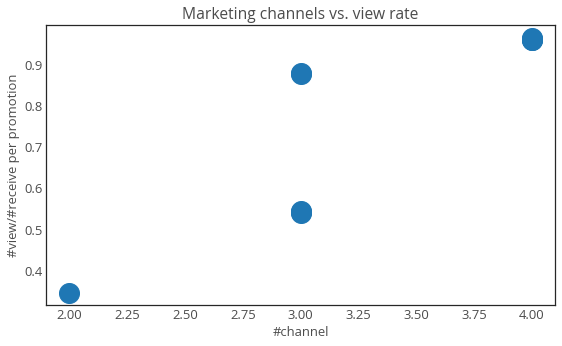

In [105]:
# ratio of views and advertising channels
plt.figure(figsize=(8,5))
plt.plot(portfolio_extra[['email', 'mobile', 'web', 'social']].sum(axis=1),
         portfolio_extra['view/receive'],
        ls='', marker='o', markersize=20)
plt.title('Marketing channels vs. view rate')
plt.ylabel('#view/#receive per promotion')
plt.xlabel('#channel')
plt.tight_layout()
plt.savefig('img/view_rate.png', optimize=True, dpi=120)

summary:
- more marketing channels resulted a higher view rate
- all promotion has email as one of the channel
- view rate is not linear over each channel, 
    - without social marketing, the view rate is about 0.54 (or 54% customers saw their promotion)
    - without social plus mobile, the view rate drops to 0.35
    - without web marketing, the view rate is 0.87, which is the least influence channels
    - all promotion sent via email so we are not able to draw any relation on this channel

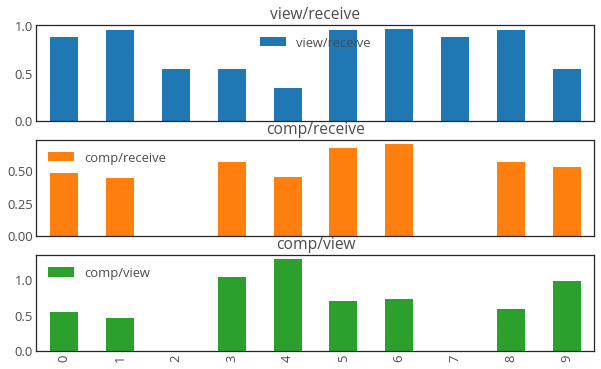

In [106]:
# let see all the rates with each promotion id
categories = ['view/receive','comp/receive', 'comp/view']
portfolio_extra[categories].plot(kind='bar', subplots=True);

**Successful rate of completion**
- we will define a term to quantify a successful transaction by:
        s_rate = 1 - (#completed/ #received)*(#completed/ #viewed)

for each transaction or overall users in this dataset. 
- in a perfect case, an offer was received, viewed, then completed, `s_rate = 0`
- if a customer received an offer, NOT see the offer, but still completed the offer, the `s_rate = -infinity`
- if a customer received an offer, saw the offer, but not completed the offer, the `s_rate = 1`
- if we want to find the most successful transaction, we can use the absolute value (`abs(s_rate)`) of s_rate, in which s_rate close to zero is more sucess than larger (a far away) from zero.


In [107]:
# for a simpler approach, I will use the ratio of (completed/received)*(completed/viewed)
# as one rating for how succesful the promotion is. This is only applicable for discount for BOGO
categories = ['view/receive','comp/receive', 'comp/view']
portfolio_extra['s_rate'] = 1 - portfolio_extra['comp/receive']*portfolio_extra['comp/view']

In [108]:
portfolio_extra.columns

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id',
       'offer completed', 'offer received', 'offer viewed', 'view/receive',
       'comp/receive', 'comp/view', 'social', 'web', 'email', 'mobile',
       's_rate'],
      dtype='object')

In [109]:
portfolio_extra[['id', 'offer_type', 'difficulty', 'duration', 's_rate']].\
sort_values(by='s_rate', ascending=True)

,id,offer_type,difficulty,duration,s_rate
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,7,0.407968
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,10,0.427205
9,2906b810c7d4411798c6938adc9daaa5,discount,10,7,0.486573
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,10,0.492115
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,7,0.526115
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,0.664417
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,7,0.735543
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,5,0.799769
2,3f207df678b143eea3cee63160fa8bed,informational,0,4,NaN
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,3,NaN


In [110]:
def find_pop_offers(transcript, portfolio):
    '''find offer that has a high successful rate
    
    INPUT:
        transcript: dataframe of records of transaction of customers with promo offered
        portfolio: information of promotion including type, duration, difficulty
        
    OUTPUT:
        a sorted offers which show the highest successful rate `s_rate`.
        s_rate = (number of completed/number of received)*(number of viewed/number of received)
        for each promotion
    '''
    
    df = transcript.groupby(['offer', 'event']).count()['person'].unstack()
    df.index.set_names(names='id', inplace=True)
    
    df['view/receive'] = df.apply(lambda row: row['offer viewed']/row['offer received'], axis=1)
    df['comp/receive'] = df.apply(lambda row: row['offer completed']/row['offer received'], axis=1)
    df['comp/view'] = df.apply(lambda row: row['offer completed']/row['offer viewed'], axis=1)
    
    df = portfolio.merge(df, how='right', left_on='id', right_on='id')
    
    # define an `s_rate` as sucessful rate based on completion
    df['s_rate'] = abs(1-df['comp/receive']*df['comp/view'])
    offers = df[['id', 'offer_type', 'difficulty', 'duration',
                     's_rate']].sort_values(by='s_rate', ascending=True)
    return offers

In [111]:
ranked_offers = find_pop_offers(transcript, portfolio)
ranked_offers

,id,offer_type,difficulty,duration,s_rate
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,7,0.407968
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,10,0.427205
9,2906b810c7d4411798c6938adc9daaa5,discount,10,7,0.486573
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,10,0.492115
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,7,0.526115
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,0.664417
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,7,0.735543
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,5,0.799769
2,3f207df678b143eea3cee63160fa8bed,informational,0,4,NaN
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,3,NaN


In [112]:
labels = ranked_offers[['id', 'offer_type']].apply(
    lambda row: row['offer_type']+'_' + row['id'][-5:], axis=1).values
labels

array(['bogo_9e6d9', 'discount_2e1d7', 'discount_daaa5', 'discount_fc2a4',
       'discount_fb8c2', 'bogo_0e20d', 'bogo_0ddfd', 'bogo_e8da0',
       'informational_a8bed', 'informational_b9837'], dtype=object)

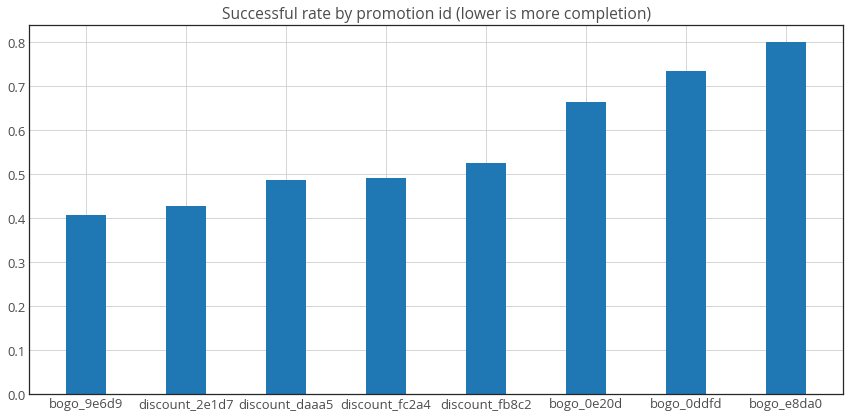

In [113]:
plt.figure(figsize=(12,6))
plt.bar(x=labels, height=ranked_offers['s_rate'], width=0.4)
plt.xticks(rotation=0)
plt.title('Successful rate by promotion id (lower is more completion)')
plt.tight_layout()
plt.grid()
plt.savefig('img/s_rate.png', optimize=True, dpi=120);


In [114]:
transcript.amount.describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

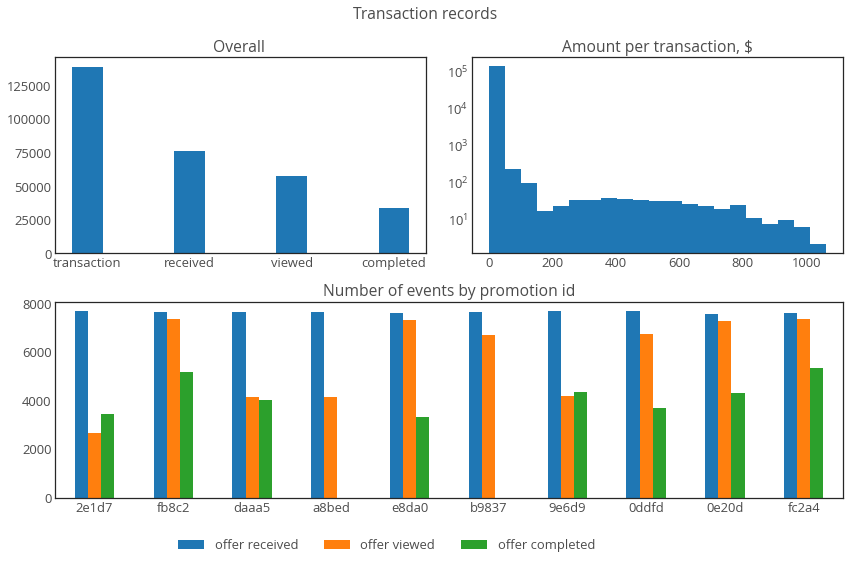

In [115]:
plt.figure(figsize=(12,8))
# plt.subplot_adjust(h_space=0.5)
plt.suptitle('Transaction records')

ax1 = plt.subplot(221)
ax1.set_title('Overall ')
df_ = transcript.event.value_counts()
short_labels = [label.split(' ')[-1] for label in df_.index]
ax1.bar(x=short_labels, height=df_.values, width=0.3)

ax2 = plt.subplot(222)
ax2.set_title('Amount per transaction, $')
ax2.hist(transcript.amount, log=True, bins=21)

ax3 = plt.subplot(212)
ax3.set_title('Number of events by promotion id')
df_ = transcript.groupby(['offer', 'event']).count()['time'].unstack()
sort_labels = [label[-5:] for label in df_.index]
df_[['offer received', 'offer viewed', 'offer completed']].plot(kind='bar', ax=ax3)
ax3.set_xticklabels(sort_labels, rotation=0)
ax3.legend(loc='best', ncol=3, bbox_to_anchor=(0.2, 0., 0.5, -0.15))
ax3.set_xlabel('')

# # axs[1,0].bar(df_.index, df_.values)
plt.tight_layout()
plt.savefig('img/transaction.png', optimize=True, dpi=120)

## Grouping transaction by users

In [116]:
def analyze_df(df, offer_id, info_offer=False):    
    '''summary a transaction if it was viewed, other offer, and amount spent.
    
    INPUT:
        df: a dataframe containing transaction records
        offer_id: an promotion id about an offer
        
    OUPUT:
        a dictionary containing summary
    '''
#     print(df)
    start_idx = df.head(1).index[0]
    result = {'viewed': False,
              'completed': False,
              'other offer viewed': False,
              'amount': 0}
    count_viewed_offers  = df.query('event=="offer viewed"')['offer'].value_counts().index
    if offer_id in count_viewed_offers:
        result['viewed'] = True
        if len(count_viewed_offers) > 1:
            result['other offer viewed'] = True
    amount = df['amount'].sum()
    result['amount'] = amount
    
    if info_offer:
        # for informational offer, if we saw at least one transaction, we marked it as a completed one
        if len(df['offer']=='transaction') >0:
            result['completed'] = True
    else:
        # for discount for BOGO offers, we look for "offer completed" in event columns
        if offer_id in df.query('event=="offer completed"')['offer'].values:
            result['completed'] = True
    return {start_idx: result}

In [117]:
def slice_df(df, start_point, valid_hours):
    '''slice a dataframe based on duration of offer since it's received.
    
    INPUT:
        df: a larger dataframe contains all transaction records
        start_point: starting index, usually when offer is received
        valid_hours: duration of offer to be valid
    OUPUT:
        a sliced dataframe     
    '''
    
    time_track = df.loc[start_point]['time']
    time_expired = time_track + valid_hours
    
    # 
    for idx, row in df[['offer', 'event', 'time', 'amount']].loc[start_point:,].iterrows():
        time_expired = time_track + valid_hours
        if row['time'] > time_expired:
            return df.loc[start_point:idx]
        else:
            return df.loc[start_point:]

In [118]:
portfolio.query('offer_type=="informational"').id.values

array(['3f207df678b143eea3cee63160fa8bed',
       '5a8bc65990b245e5a138643cd4eb9837'], dtype=object)

In [119]:
transcript.groupby('event').count()

,person,time,amount,offer
event,,,,
offer completed,33579,33579,0,33579
offer received,76277,76277,0,76277
offer viewed,57725,57725,0,57725
transaction,138953,138953,138953,0


In [120]:
transcript.head()

,person,event,time,amount,offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [121]:
def info_offer(user, transcript, portfolio):
    '''summary of offers for each user by itering through each promotion and count numbers 
    of received, viewed, and completed transaction.
    
    INPUT:
        person: an id associated with an user
        portfolio: a dataframe containg promotion id and valid hours
    
    OUTPUT:
        a list of dictionary with person_id as the key and summary stat as the value
    '''
    # slice the main dataset to each user/person with 4 columns
    df = transcript.query('person==@user')[['time', 'offer', 'event', 'amount']]
    res = dict()
    
    for offer in portfolio['id'].values:
        # if informational offer, we count one transaction for completion
        if offer in portfolio.query('offer_type=="informational"').id.values:
            info_offer = True
        else:
            info_offer = False
        num_offer = df.query(f'offer=="{offer}" & event=="offer received"').index
        valid_hours = portfolio.query(f'id=="{offer}"')['duration'].values[0]*24
        offer_stats = []
        for segment in num_offer:      
            dft = slice_df(df, segment, valid_hours)
            result = analyze_df(dft, offer, info_offer=info_offer)
            offer_stats.append(result)
            
        
        # summary over each offer
        result = {
            'viewed': 0,
            'completed': 0,
            'other offer viewed': 0,
            'amount': 0}
        
        # counting all offer for each promotion id
        result['received'] = len(num_offer)
        result['info'] = info_offer
        for stat in offer_stats:
            stat_v = list(stat.values())[0]
            result['viewed'] += stat_v['viewed']
            result['completed'] += stat_v['completed']
            result['other offer viewed'] += stat_v['other offer viewed']
            result['amount'] += stat_v['amount']   
            
        res[offer] = result
        
    return res

In [122]:
# iterate through all users and make a summary of transaction based on offer id
# the would take 20 minutes to complete
def user_transaction(transcript=None, portfolio=None, save_file=True):
    info_res = dict()
    max_value = transcript['person'].nunique()
    i= 0
    with progressbar.ProgressBar(max_value=max_value) as bar:
        for person in transcript['person'].unique():
            person_ = info_offer(person, transcript, portfolio)
            info_res[person] = person_
            i +=1
            bar.update(i)
    df_info = pd.DataFrame.from_dict(data=info_res, orient='index')
    if save_file:
#          save to file, and save 20 minutes if we need to load them 
        df_info.to_json('data/offer_summary.json')
    return df_info

If you want to test the grouping transaction with with person, this is a screenshot. Otherwise, change `LOAD_JSON` from `True` to `False` at the beginning of the file
![grouping](./img/grouping_transcript.png)

In [123]:
# LOAD_JSON = False
if not LOAD_JSON:  
    import progressbar
    df_info = user_transaction(transcript=transcript, portfolio=portfolio)
    df_info
else:
    df_info = pd.read_json('data/offer_summary.json')

In [124]:
# make a short label from portfolio dataframe
labels = portfolio[['id', 'offer_type']].apply(
    lambda row: row['offer_type'][:4]+'_' + row['id'][-5:], axis=1).values
labels

array(['bogo_0ddfd', 'bogo_e8da0', 'info_a8bed', 'bogo_9e6d9',
       'disc_2e1d7', 'disc_fb8c2', 'disc_fc2a4', 'info_b9837',
       'bogo_0e20d', 'disc_daaa5'], dtype=object)

In [125]:
# compare the total dollars spent for each transaction
df_amount = pd.DataFrame()
amounts = dict()
df_info.columns = labels

for offer in df_info.columns:
    df_amount[offer] = df_info[offer].apply(lambda x: x['amount']/x['received'] if x['received']>0 else np.NaN)

# save average values to a dictionary
amounts['received'] = df_amount.describe().loc['mean'].to_dict()

In [126]:
# for viewed event
df_amount = pd.DataFrame()

# average spending per transaction if offer NOT viewed
for offer in df_info.columns:
    df_amount[offer] = df_info[offer].apply(lambda x: x['amount'] if x['viewed']==0 else np.NaN)
amounts['not_viewed'] = df_amount.describe().loc['mean'].to_dict()

# if offer was viewed
for offer in df_info.columns:
    df_amount[offer] = df_info[offer].apply(lambda x: x['amount']/x['viewed'] if x['viewed']>0 else np.NaN)

amounts['viewed'] = df_amount.describe().loc['mean'].to_dict()

In [127]:
# for transaction not completed
df_amount = pd.DataFrame()

for offer in df_info.columns:
    df_amount[offer] = df_info[offer].apply(lambda x: x['amount'] if x['completed']==0 else np.NaN)
amounts['not_completed'] = df_amount.describe().loc['mean'].to_dict()

# and completed transaction
for offer in df_info.columns:
    df_amount[offer] = df_info[offer].apply(lambda x: x['amount']/x['completed'] if x['completed']>0 else np.NaN)
amounts['completed'] = df_amount.describe().loc['mean'].to_dict()

In [128]:
df_amount = pd.DataFrame().from_dict(amounts, orient='index')
df_amount

,bogo_0ddfd,bogo_e8da0,info_a8bed,bogo_9e6d9,disc_2e1d7,disc_fb8c2,disc_fc2a4,info_b9837,bogo_0e20d,disc_daaa5
received,67.218247,62.750001,57.121911,59.941433,60.821514,65.921883,73.419654,57.586230,63.686810,60.508045
not_viewed,3.743031,0.779446,10.407721,10.434195,15.645375,0.936955,0.659348,3.474268,0.702877,9.540901
viewed,69.483594,63.740506,67.885741,74.073113,83.973485,66.862277,74.839473,58.625532,64.995385,77.513573
not_completed,6.003985,6.701045,0.000000,4.601920,5.219426,2.432115,1.736225,0.000000,4.530091,4.245381
completed,112.914666,110.385598,57.121911,87.067981,109.958177,88.598051,98.760348,57.586230,93.356191,95.669480


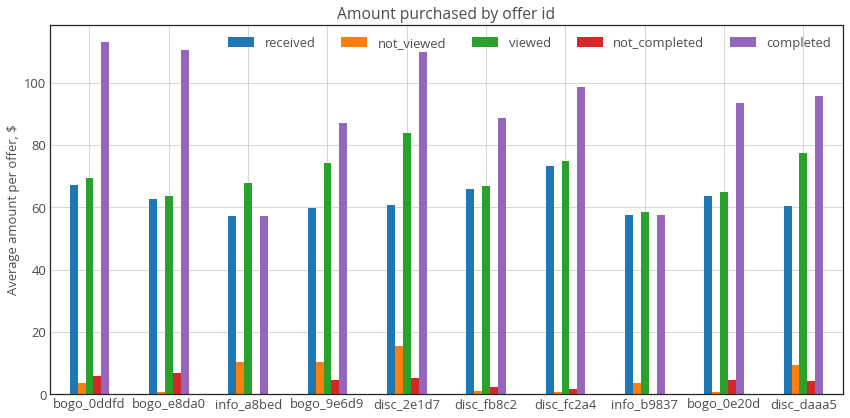

In [129]:
fig, ax = plt.subplots(figsize=(12,6))
df_amount.transpose().plot(kind='bar', ax=ax)
ax.legend(ncol=5)
ax.set_title('Amount purchased by offer id')
ax.set_ylabel('Average amount per offer, $')
ax.set_xticklabels(labels=df_amount.columns, rotation=0)
ax.grid()
fig.tight_layout()
fig.savefig('img/count_event.png', optimize=True, dpi=120)

In [130]:
df_amount.loc['viewed']/df_amount.loc['not_viewed']

bogo_0ddfd     18.563458
bogo_e8da0     81.776672
info_a8bed      6.522633
bogo_9e6d9      7.099073
disc_2e1d7      5.367304
disc_fb8c2     71.361222
disc_fc2a4    113.505204
info_b9837     16.874211
bogo_0e20d     92.470550
disc_daaa5      8.124346
dtype: float64

remarks:
    - one transaction marked completion of informational offer is not sufficient to distinguish. All received offers were completed based on this assumption, which is minimal.
    - when a BOGO and discount offer was viewed, the total transaction during the offer was valid make a huge different to the offer not viewed. Similar observation with completed event on offer
    - the total dollar spent was 7 to 100 times more with offer that user saw. The precaution is that this is confounding with activeness of users. If users used the Starbucks product more, they should checked the app or promotion more offen, made more purchase in general.    

# Recommendation system

## Approach


- if a user is on the database and have completed of a few offesr, combining promotion by user history purchase and user similarity purchase
- if a user is totally new to the app, recommend the top promotion by overall population

In [131]:
# load group transaction from json file
df_info = pd.read_json('data/offer_summary.json')
encoded_profile = encoding_profile(df=profile)

In [132]:
def evaluate_similar_users(user_id, profile_df=None, 
                           info_df=None, sort_amount=False, n_top=100):
    '''evaluate similar users responded to promotions
    
    INPUT: a dataframe containing similar users responses to promotion
    
    OUTPUT: a dataframe sorted by sucessful rate of view, complete 
    and average amount of purchase  
    '''
    users = find_similar_users(user_id, df=profile_df, n_top=n_top)
    users = [item['user'] for item in users]
    df_users = info_df.loc[users]

    cols = df_users.columns
    ranking = dict()
    for col in cols:
        receives = df_users[col].apply(lambda x: x['received']).sum()
        completes = df_users[col].apply(lambda x: x['completed']).sum()
        views = df_users[col].apply(lambda x: x['viewed']).sum()
        amount_avg = df_users[col].apply(lambda x: x['amount']).mean()
        
        # rank metrics
        ranking[col] = {'rank': abs(1-completes**2/(views*receives)),
                        'amount': amount_avg}
    ranks = pd.DataFrame().from_dict(ranking,orient='index')
    
    if not sort_amount: # sort by completion rate first then amount
        ranks = ranks.sort_values(['rank', 'amount'], ascending=[True, False])
    else: # by amount first, then rank
        ranks = ranks.sort_values(['amount', 'rank'], ascending=[False, True])
    ranks = {k:round(v,2) for k,v in ranks['amount'].to_dict().items()} 
    return ranks

In [133]:
def evaluate_user_history(user_id, df=None):
    '''evaluate user history preference by evaluating number of view and completion
    on each promotion
    
    INPUT: a user_id - a string encoded for each user
        df: a dataframe encoded user demographic
        
    OUTPUT: a ranking dictionary containing promotion id and amount of 
    dollar purchased on offers that have number of views equals to number
    of completion
    '''
    
    dft = df.loc[user_id]
    user_hist = dict()
    for promotion in dft.index:
        dft_ = dft.loc[promotion]
        if dft_['viewed'] == dft_['completed'] > 0:
            user_hist[promotion] = dft_['amount']
#             print(dft.loc[promotion])
    user_hist = {k:v for k,v in sorted(user_hist.items(), 
                                        key=lambda item: item[1],
                                      reverse=True)}
    return user_hist

In [142]:
def recommend_offers(user_id, profile_df=encoded_profile, info_df=df_info, sort_amount=False):
    '''recommend a few promotions for a user based on user history preference,
    group similarity, overall 
    
    INPUT: user_id (str) - user identification on dataset
    
    OUTPUT: a dictionary of top three promotions with expected dollar spent
    '''
    
    # existing users:
    if user_id in profile_df.index:
        offers = evaluate_similar_users(user_id, profile_df=profile_df, 
                                            info_df = info_df, sort_amount=sort_amount)
        user_pref = evaluate_user_history(user_id, df=info_df)
        
        # if user make a large dollar amount, the group preference will be updated
        for k,v in user_pref.items():
            if v > offers[k]:
                offers[k] = v
        if sort_amount:
            offers = {k:v for k,v in sorted(offers.items(), 
                                            key=lambda item: item[1],
                                            reverse=True)}
    else: # new user
        offers  = find_pop_offers(transcript, portfolio).set_index('id')['s_rate'].to_dict()
    
    offers = {k: round(v,2) for k,v in offers.items()}
    return offers

## Test recommendation

In [135]:
import random
random.seed(2021)
max_idx = len(profile)

In [136]:
user_idx = random.randint(0, max_idx)
user_id = profile.iloc[user_idx].id
user_id
# '3713b8ef49c541beaa07ed83ed0136d5'

'ddce9ae854314d8cb347db0a7b5db9f8'

In [137]:
# group preference
group = evaluate_similar_users(user_id, profile_df=encoded_profile, 
                               info_df=df_info, sort_amount=True)
group

{'f19421c1d4aa40978ebb69ca19b0e20d': 56.97,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 45.9,
 '5a8bc65990b245e5a138643cd4eb9837': 44.15,
 '2906b810c7d4411798c6938adc9daaa5': 30.41,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 28.37,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 25.76,
 'ae264e3637204a6fb9bb56bc8210ddfd': 25.07,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 23.66,
 'fafdcd668e3743c1bb461111dcafc2a4': 21.32,
 '3f207df678b143eea3cee63160fa8bed': 19.28}

In [138]:
# user preference
user = evaluate_user_history(user_id, df=df_info)
user

{'3f207df678b143eea3cee63160fa8bed': 0.0}

In [139]:
# based on both the user and similar users preference
recommend_offers(user_id=user_id, profile_df=encoded_profile, 
                    info_df=df_info, sort_amount=False)

{'0b1e1539f2cc45b7b9fa7c272da2e1d7': 45.9,
 '5a8bc65990b245e5a138643cd4eb9837': 44.15,
 'ae264e3637204a6fb9bb56bc8210ddfd': 25.07,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 23.66,
 '2906b810c7d4411798c6938adc9daaa5': 30.41,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 28.37,
 'f19421c1d4aa40978ebb69ca19b0e20d': 56.97,
 'fafdcd668e3743c1bb461111dcafc2a4': 21.32,
 '3f207df678b143eea3cee63160fa8bed': 19.28,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 25.76}

In [140]:
recommend_offers(user_id=user_id, profile_df=encoded_profile, 
                    info_df=df_info, sort_amount=True)

{'f19421c1d4aa40978ebb69ca19b0e20d': 56.97,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 45.9,
 '5a8bc65990b245e5a138643cd4eb9837': 44.15,
 '2906b810c7d4411798c6938adc9daaa5': 30.41,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 28.37,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 25.76,
 'ae264e3637204a6fb9bb56bc8210ddfd': 25.07,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 23.66,
 'fafdcd668e3743c1bb461111dcafc2a4': 21.32,
 '3f207df678b143eea3cee63160fa8bed': 19.28}

In [143]:
# new user, this show the rate of completion 
recommend_offers(user_id='new_user')

{'9b98b8c7a33c4b65b9aebfe6a799e6d9': 0.41,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 0.43,
 '2906b810c7d4411798c6938adc9daaa5': 0.49,
 'fafdcd668e3743c1bb461111dcafc2a4': 0.49,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 0.53,
 'f19421c1d4aa40978ebb69ca19b0e20d': 0.66,
 'ae264e3637204a6fb9bb56bc8210ddfd': 0.74,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 0.8,
 '3f207df678b143eea3cee63160fa8bed': nan,
 '5a8bc65990b245e5a138643cd4eb9837': nan}

# Summary

- In this *simulated* dataset featuring Starbucks promotion. The dataset including three `json` files:

    - **portfolio**: a table of 10 rows by 6 columns listed 10 promotion id, four of them are discounts, four of them are BOGO (Buy One Get One free), and two are informational which is informing customer a new product or service
    - **profile**: a table of 17000 rows by 6 columns listed user demographic data such age, income, year of membership, user_id, gender
    - **transcript**: a table of 306 534 rows by 5 columns listed all transaction during simulating periods. This a main file with a long-table format that records when promotion is received, viewed or completed with a mount of dollar in each transaction


- Data Exploration and Analysis: 
    - this include exploratory steps on **portfolio** table. The portfolio data is important to refer to characteristics of each promotion. 
    - analysis on **profile** were mainly on distribution by histogram using cleaning out abnormal values (age). The most important function built out of profile data is `find_similar_users` by ranking `nump.dot` of *encoded* user profile. This function is used to finding a similar group of users given a particular `user_id`.
    - high level summary on **transcript** is available without changing structure of the table such as the number of received, viewed, and completed events on each promotion. Similar to **movie recommender**, the transcript table contains information to build a `user-offer-matrix`


- Attempt with Single Value Decomposition (SVD) for collaborative filtering
    - the `user-offer` matrix is the first step to reconstruct a **user-latent features** and **offer-latent features** to calculate **user preference's similarity** 
    - I attempted `FunkSVD` and `Surprise SVD` to decompose `user-offer` matrix, but I failed to get reliable matrices. In fact, the algorithms did not able to "converged" resulted in a biased RMS or a NaN values


- Grouping transaction by user
    - this is an alternative approach, in which each offer for each person was summarized based on *received, viewed, completed* events and transaction amount. The summary of each offer was then aggregated to `person-offer-stats` frame. We can use this dataframe to pull out amount of each transaction by each user, the completed rate on each transaction by user
    - one big caveat of this approach is a biased ranking. I ranked each transaction by two metrics:
        - rate of completion = 1- (\#completed)**2)/(\#viewed*\#received)
        - and amount of dollar spent
        
        which is subjective to my selection. However, with the context of effectiveness of promotion, the first metrics seems resonable, and the second metrics would be find for business.
        

- Recommendation system: a short summary, the function returns ranked dictionary from a mixed of **similar users** on **rate of completion** and **dolar spent** and **user history preference** if that user is **existed** in database; otherwise, the function returns a ranked dictionary based on `find_pop_offers` which is ranked **completion rate** based on the average of all users in this dataset.   